Sampling rate=  32000
[   0    0    0 ... 1555  819  124]
Data type is  int16
Number of samples:  506880


Text(0.5, 1.0, 'Whitened data')

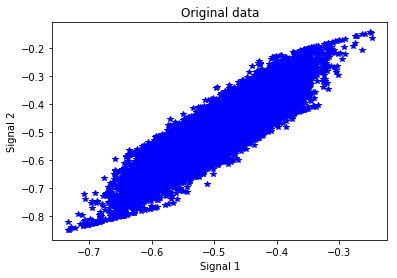

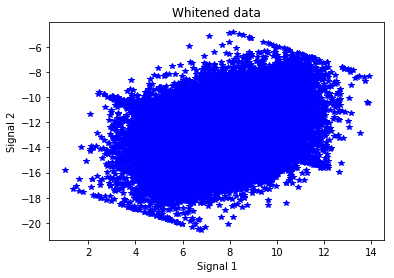

In [218]:
%matplotlib inline
"""
Voice Isolation System solved via Independent Component Analysis.
The fastICA algorithm is implemented here.
"""
# Import packages.
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from scipy.io import wavfile
from scipy import linalg as LA
from numpy.random import randn as RNDN

def g(x):
    out = np.tanh(x)
    return out


def dg(x):
    out = 1 - g(x) * g(x)
    return out

# Dimension
dim = 2

# Input the data from the first receiver.
samplingRate, signal1 = wavfile.read('real/mixedA.wav')
#mfcc_feat = features.mfcc(samplingRate, signal1)
signal1=np.asarray(signal1, dtype='int16')
samplingRate=np.asarray(samplingRate, dtype='int16')
print ("Sampling rate= ", samplingRate)

print (signal1)

# Convert the signal so that amplitude lies between 0 and 1.   65535.0
#signal = np.asarray(signal1, dtype=np.int16)
print ("Data type is ", signal1.dtype)
# uint8 takes values from 0 through 255; sound signals are oscillatory
signal1 = signal1 / 65535.0 -0.5
#print (signal1)
# Output information about the sound samples.
a = signal1.shape
n = a[0]
print ("Number of samples: ", n)
n = n * 1.0

# Input data from the first receiver and standardise it's amplitude.
samplingRate, signal2 = wavfile.read('real/mixedB.wav')
signal2=np.asarray(signal2, dtype='int16')
samplingRate=np.asarray(samplingRate, dtype='int16')
signal2 = signal2 / 65535.0 - 0.5

# x is our initial data matrix.
x = [signal1, signal2]

# Plot the signals from both sources to show correlations in the data.
plt.figure()
plt.plot(x[0], x[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Original data")

# Calculate the covariance matrix of the initial data.
cov = np.cov(x)
# Calculate eigenvalues and eigenvectors of the covariance matrix.
d, E = LA.eigh(cov)
# Generate a diagonal matrix with the eigenvalues as diagonal elements.
D = np.diag(d)

Di = LA.sqrtm(LA.inv(D))
# Perform whitening. xn is the whitened matrix.
xn = np.dot(Di, np.dot(np.transpose(E), x))

# Plot whitened data to show new structure of the data.
plt.figure()
plt.plot(xn[0], xn[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Whitened data")


(2, 1, 506880)


'\n# Plot the actual sources for comparison.\nsamplingRate, orig1 = wavfile.read(\'Data_set/source1.wav\')\norig1 = orig1 / 65535.0 - 0.5  # uint8 takes values from 0 to 255\n\nplt.subplot(2,2, 3).set_axis_off()\nplt.plot(time, orig1, color=\'k\')\nplt.ylabel(\'Amplitude\')\nplt.xlabel(\'Time (ms)\')\nplt.title("Original signal 1")\n\nsamplingRate, orig2 = wavfile.read(\'Data_set/source2.wav\')\norig2 = orig2 / 65535.0 - 0.5  # uint8 takes values from 0 to 255\n\nplt.subplot(2, 2, 4).set_axis_off()\nplt.plot(time, orig2, color=\'k\')\nplt.ylabel(\'Amplitude\')\nplt.xlabel(\'Time (ms)\')\nplt.title("Original signal 2")\n'

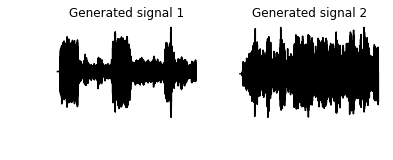

In [271]:
# Now that we have the appropriate signal,
# we proceed to implement fastICA on the source signal 'x'

# Creating random weight vector
w1 = RNDN(dim, 1)
w1 = w1 / LA.norm(w1)

w0 = RNDN(dim, 1)
w0 = w0 / LA.norm(w0)


# Running the fixed-point algorithm, with gradient descent
epsilon = 0.01  # Determines the extent of convergence
alpha = 1  # Step-size for gradient-descent


while (abs(abs(np.dot(np.transpose(w0), w1)) - 1) > 0.01):
    w0 = w1
    w1 = np.dot(xn, np.transpose(g(np.dot(np.transpose(w1), xn)))) / \
        n - alpha * \
        np.transpose(np.mean(np.dot(dg(np.transpose(w1)), xn), axis=1)) * w1
    w1 = w1 / LA.norm(w1)

w2 = RNDN(dim, 1)
w2 = w2 / LA.norm(w2)

w0 = RNDN(dim, 1)
w0 = w0 / LA.norm(w0)

while (abs(abs(np.dot(np.transpose(w0), w2)) - 1) > 0.01):
    w0 = w2
    w2 = np.dot(xn, np.transpose(g(np.dot(np.transpose(w2), xn)))) / \
        n - alpha * \
        np.transpose(np.mean(np.dot(dg(np.transpose(w2)), xn), axis=1)) * w2
    w2 = w2 - np.dot(np.transpose(w2), w1) * w1
    w2 = w2 / LA.norm(w2)

# Forming the source signal matrix
w = np.transpose([np.transpose(w1), np.transpose(w2)])
s = np.dot(w, x)
print( s.shape)

# Plot the separated sources.
time = np.arange(0, n, 1)
time = time / samplingRate
time = time * 1000  # convert to milliseconds

plt.figure()
plt.subplot(2, 2, 1).set_axis_off()
plt.plot(time, s[0][0], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 1")

plt.subplot(2, 2, 2).set_axis_off()
plt.plot(time, s[1][0], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 2")

'''
# Plot the actual sources for comparison.
samplingRate, orig1 = wavfile.read('Data_set/source1.wav')
orig1 = orig1 / 65535.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2,2, 3).set_axis_off()
plt.plot(time, orig1, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 1")

samplingRate, orig2 = wavfile.read('Data_set/source2.wav')
orig2 = orig2 / 65535.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2, 2, 4).set_axis_off()
plt.plot(time, orig2, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 2")
'''

[0.16975068 0.16975068 0.16975068 ... 0.17040906 0.17008044 0.16980072]
[14428 14428 14428 ... 14484 14456 14433]
[ 326  326  326 ... 2921 1694  533]


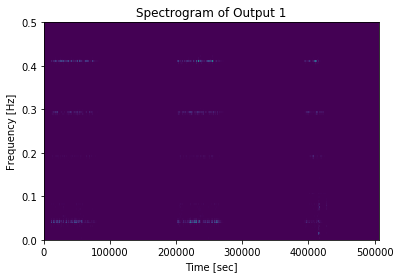

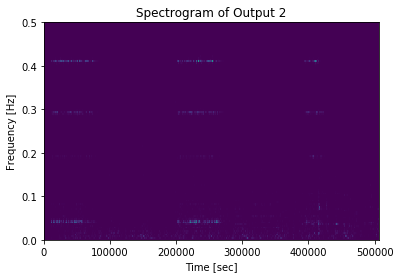

In [264]:
plt.figure()
f, t, S = signal.spectrogram(s[0][0])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 1')

plt.figure()
f, t, S = signal.spectrogram(s[1][0])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 2')

data1= np.asarray((s[0][0])*85000, dtype=np.int16)
data2= np.asarray((s[1][0])*95000, dtype=np.int16)

print(s[0][0])
print( np.abs(data1))
print (np.abs(data2))

# Storing numpy array as audio
wavfile.write('Data_set_4/out1.wav', samplingRate, (data1))
wavfile.write('Data_set_4/out2.wav', samplingRate, (data2))

In [265]:
from IPython.display import Audio
print('Mixed Signal 1')
Audio("real/mixedA.wav")

Mixed Signal 1


In [266]:
print('Mixed Signal 2')
Audio("real/mixedB.wav")

Mixed Signal 2


In [267]:
#print('Original separated signal 1')
#Audio("Data_set/source1.wav")

In [268]:
#print('Original separated signal 2')
#Audio("Data_set/source1.wav")

In [269]:
print('Separated signal 1 (output)')
Audio("real/out1.wav")

Separated signal 1 (output)


In [270]:
print('Separated signal 2 (output)')
Audio("real/out2.wav")

Separated signal 2 (output)
